In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

%matplotlib inline

In [229]:
def dft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1j / N )
    W = np.power( omega, i * j )
    return W

def idft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp(2 * np.pi * 1j / N )
    W = np.power( omega, i * j ) / N
    return W

def dft(I):
    (M, N) = I.shape
    
    W_N = dft_matrix(N)
    W_M = dft_matrix(M)
    
    It = np.zeros((M, N), dtype=complex)
    It = W_M@I@W_N
    return It

def idft(It):
    (M, N) = It.shape
    W_N = idft_matrix(N)
    W_M = idft_matrix(M)
    
    I = np.zeros((M, N), dtype=int)
    I = np.clip(np.real(W_M@It@W_N), 0, 255)
    return I

def CONVOLVE(f, h):
    (M, N, C) = f.shape
    (m, n, c) = h.shape
    mid_m = (m-1)//2
    mid_n = (n-1)//2
    if C != c:
        print("Channel diemensions are mismatching f:{} and h:{}".format(C, c))
        return None
    y = np.zeros((M, N))
    for i in range(C):
        h_padded = np.vstack((np.hstack((h[:, :, i], np.zeros((m, 2*N - n)))), np.zeros((2*M-m, 2*N))))
        f_padded = np.vstack((np.hstack((f[:, :, i], np.zeros((M, N)))), np.zeros((M, 2*N))))
        y[:, :] += idft(dft(h_padded) * dft(f_padded))[mid_m:(M+mid_m), mid_n:(N+mid_m)]
    return y.astype(int)

def gaussian_filter(sigma, N, C):
    H = np.zeros((N, N, C))
    for k in range(C):
        mid = N//2
        for i in range(N):
            for j in range(N):
                H[i, j, k] = np.exp(-2*np.power(np.pi*sigma, 2)*((mid-i)**2 + (mid-j)**2)/(N**2))
        H[:, :, k] = H[:, :, k]/np.sum(H[:, :, k])
    return H

In [144]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [13]:
images = unpickle("./cifar-10-python/cifar-10-batches-py/data_batch_1")
print(images.keys())
print(images[b'data'].shape)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
(10000, 3072)


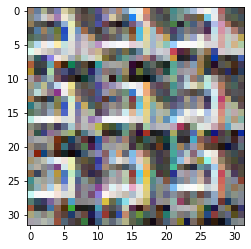

In [17]:
r = images[b'data'][1,:].reshape(32, 32, 3)
plt.imshow(r)

In [29]:
def extract_data(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    images = []
    for i in range(data.shape[0]):
        img = np.zeros((32, 32, 3), dtype=int)
        for j in range(data.shape[1]):
            x = j//1024
            img[(j - 1024*x)//32, (j - 1024*x)%32, x] = data[i, j]
        images.append(img)
    dct = {'X':np.array(images), 'Y':labels}
    return dct

In [41]:
%%time
data = extract_data("./cifar-10-python/cifar-10-batches-py/data_batch_1")

CPU times: user 11.8 s, sys: 24.4 ms, total: 11.8 s
Wall time: 11.6 s


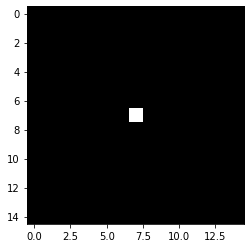

In [274]:
h = gaussian_filter(sigma=100, N=15, C=3)
plt.imshow(h)

In [275]:
image = data['X'][0, :]
h_image = CONVOLVE(image, h)

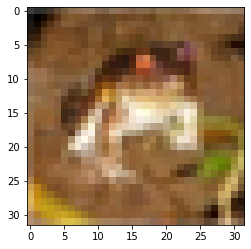

In [276]:
plt.imshow(image)

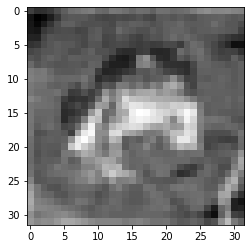

In [277]:
plt.imshow(h_image, cmap='gray')

In [215]:
print(h_image.shape)

(32, 32)


In [216]:
def max_pool(image):
    (M, N, C) = image.shape
    if M!=N:
        print("Not implemented!")
        return None
    m = M//2
    y = np.zeros((m, m, C), dtype=int)
    for k in range(C):
        for i in range(m):
            for j in range(m):
                y[i, j, k] = np.max(image[(2*i):(2*i+2), (2*j):(2*j+2), k])
    return y

def ReLU(x):
    return np.clip(x, 0, None)

In [475]:
def weight_init(init_type='random', sigma=None):
    kernel_1=None
    kernel_2=None
    W1=None
    b1=None
    W2=None
    b2=None
    if init_type == 'random':
        kernel_1 = {'0':np.random.rand(3, 3, 3), '1':np.random.rand(3, 3, 3), '2':np.random.rand(3, 3, 3),
                    '3':np.random.rand(3, 3, 3)}
        kernel_2 = {'0':np.random.rand(3, 3, 4), '1':np.random.rand(3, 3, 4), '2':np.random.rand(3, 3, 4),
                    '3':np.random.rand(3, 3, 4), '4':np.random.rand(3, 3, 4), '5':np.random.rand(3, 3, 4),
                    '6':np.random.rand(3, 3, 4), '7':np.random.rand(3, 3, 4)}
        W1 = np.random.rand(256, 512)
        b1 = np.random.rand(256, 1)
        W2 = np.random.rand(10, 256)
        b2 = np.random.rand(10, 1)
    elif init_type == 'bandpass':
        sigma = 1e-2
        kernel_1 = {'0':gaussian_filter(sigma, N=3, C=3), '1':gaussian_filter(sigma, N=3, C=3), '2':gaussian_filter(sigma, N=3, C=3),
                    '3':gaussian_filter(sigma, N=3, C=3)}
        sigma = 1e-3
        kernel_2 = {'0':gaussian_filter(sigma, N=3, C=4), '1':gaussian_filter(sigma, N=3, C=4), '2':gaussian_filter(sigma, N=3, C=4),
                    '3':gaussian_filter(sigma, N=3, C=4), '4':gaussian_filter(sigma, N=3, C=4), '5':gaussian_filter(sigma, N=3, C=4),
                    '6':gaussian_filter(sigma, N=3, C=4), '7':gaussian_filter(sigma, N=3, C=4)}
        W1 = np.random.rand(256, 512)
        b1 = np.random.rand(256, 1)
        W2 = np.random.rand(10, 256)
        b2 = np.random.rand(10, 1)
    return kernel_1, kernel_2, W1, b1, W2, b2
    
def feed_forward(image, init_type='bandpass', print_dim=False, show_plot=False):
    (M, N, C) = image.shape
    
    # Weights and bias initialisation
    kernel_1, kernel_2, W1, b1, W2, b2 = weight_init(init_type=init_type)
    if print_dim:
        print("\u001b[31m ################ Input layer ##################")
        print("\t\t", "\u001b[32m{}".format(image.shape))
        
    # CONV layer with 4 kernels of size 3x3, ReLU
    x1 = np.dstack((CONVOLVE(image, kernel_1['0']), CONVOLVE(image, kernel_1['1']), 
                   CONVOLVE(image, kernel_1['2']), CONVOLVE(image, kernel_1['3'])))
    x2 = ReLU(x1)
    if print_dim:
        print("\u001b[31m # CONV layer with 4 kernels of size 3x3 & ReLU ")
        print("\t\t", "\u001b[32m{}".format(x2.shape))
        
    # Max pooling of size 2x2 with a stride of 2
    x3 = max_pool(x2)
    if print_dim:
        print("\u001b[31m ## Max pooling of size 2x2 with a stride of 2 #")
        print("\t\t", "\u001b[32m{}".format(x3.shape))
        
    # CONV layer with 8 kernels of size 3x3, ReLU
    x4 = np.dstack((CONVOLVE(x3, kernel_2['0']), CONVOLVE(x3, kernel_2['1']), CONVOLVE(x3, kernel_2['2']),
                   CONVOLVE(x3, kernel_2['3']), CONVOLVE(x3, kernel_2['4']), CONVOLVE(x3, kernel_2['5']),
                   CONVOLVE(x3, kernel_2['6']), CONVOLVE(x3, kernel_2['7'])))
    x5 = ReLU(x4)
    if print_dim:
        print("\u001b[31m # CONV layer with 8 kernels of size 3x3, ReLU #")
        print("\t\t", "\u001b[32m{}".format(x5.shape))
        
    # Max pooling of size 2x2 with a stride of 2
    x6 = max_pool(x5)
    if print_dim:
        print("\u001b[31m # Max pooling of size 2x2 with a stride of 2 ##")
        print("\t\t", "\u001b[32m{}".format(x6.shape))
        
    # Flattening layer
    x7 = x6.reshape(-1, 1)
    if print_dim:
        print("\u001b[31m ############ Flattening layer #################")
        print("\t\t", "\u001b[32m{}".format(x7.shape))
        
    # MLP hidden layer of 256 neurons
    x8 = W1@x7 + b1
    x9 = ReLU(x8)
    if print_dim:
        print("\u001b[31m ###### MLP hidden layer of 256 neurons ########")
        print("\t\t", "\u001b[32m{}".format(x9.shape))
        
    # MLP output layer of 10 neurons
    x10 = W2@x9 + b2
    y = ReLU(x10)  
    if print_dim:
        print("\u001b[31m ####### MLP output layer of 10 neurons ########")
        print("\t\t", "\u001b[32m{}".format(y.shape))
#     print(CONVOLVE(x3, kernel_2['0']))
#     print(x3)
    if show_plot:
        plt.figure()
        plt.title("Input layer")
        plt.imshow(image)
        
        plt.figure(figsize=(12, 10))
        plt.subplot(1, 4, 1)
        plt.title("Layer 0")
        plt.imshow(x2[:, :, 0], cmap='gray')
        
        plt.subplot(1, 4, 2)
        plt.title("Layer 1")
        plt.imshow(x2[:, :, 1], cmap='gray')
        
        plt.subplot(1, 4, 3)
        plt.title("Layer 2")
        plt.imshow(x2[:, :, 2], cmap='gray')
        
        plt.subplot(1, 4, 4)
        plt.title("Layer 3")
        plt.imshow(x2[:, :, 3], cmap='gray')
        
        plt.figure(figsize=(12, 12))
        plt.subplot(1, 4, 1)
        plt.imshow(x3[:, :, 0], cmap='gray')
        
        plt.subplot(1, 4, 2)
        plt.imshow(x3[:, :, 1], cmap='gray')
        
        plt.subplot(1, 4, 3)
        plt.imshow(x3[:, :, 2], cmap='gray')
        
        plt.subplot(1, 4, 4)
        plt.imshow(x3[:, :, 3], cmap='gray')
        
        plt.figure(figsize=(24, 40))
        plt.subplot(1, 8, 1)
        plt.title("Layer 0")
        plt.imshow(x5[:, :, 0], cmap='gray')
        
        plt.subplot(1, 8, 2)
        plt.title("Layer 1")
        plt.imshow(x5[:, :, 1], cmap='gray')
        
        plt.subplot(1, 8, 3)
        plt.title("Layer 2")
        plt.imshow(x5[:, :, 2], cmap='gray')
        
        plt.subplot(1, 8, 4)
        plt.title("Layer 3")
        plt.imshow(x5[:, :, 3], cmap='gray')
        
        plt.subplot(1, 8, 5)
        plt.title("Layer 4")
        plt.imshow(x5[:, :, 4], cmap='gray')
        
        plt.subplot(1, 8, 6)
        plt.title("Layer 5")
        plt.imshow(x5[:, :, 5], cmap='gray')
        
        plt.subplot(1, 8, 7)
        plt.title("Layer 6")
        plt.imshow(x5[:, :, 6], cmap='gray')
        
        plt.subplot(1, 8, 8)
        plt.title("Layer 7")
        plt.imshow(x5[:, :, 7], cmap='gray')
        
        plt.figure(figsize=(24, 40))
        plt.subplot(1, 8, 1)
        plt.imshow(x6[:, :, 0], cmap='gray')
        
        plt.subplot(1, 8, 2)
        plt.imshow(x6[:, :, 1], cmap='gray')
        
        plt.subplot(1, 8, 3)
        plt.imshow(x6[:, :, 2], cmap='gray')
        
        plt.subplot(1, 8, 4)
        plt.imshow(x6[:, :, 3], cmap='gray')
        
        plt.subplot(1, 8, 5)
        plt.imshow(x6[:, :, 4], cmap='gray')
        
        plt.subplot(1, 8, 6)
        plt.imshow(x6[:, :, 5], cmap='gray')
        
        plt.subplot(1, 8, 7)
        plt.imshow(x6[:, :, 6], cmap='gray')
        
        plt.subplot(1, 8, 8)
        plt.imshow(x6[:, :, 7], cmap='gray')
        
        plt.show()
        
    return y, x7
    

 ################ Input layer ##################
		 (32, 32, 3)
 # CONV layer with 4 kernels of size 3x3 & ReLU 
		 (32, 32, 4)
 ## Max pooling of size 2x2 with a stride of 2 #
		 (16, 16, 4)
 # CONV layer with 8 kernels of size 3x3, ReLU #
		 (16, 16, 8)
 # Max pooling of size 2x2 with a stride of 2 ##
		 (8, 8, 8)
 ############ Flattening layer #################
		 (512, 1)
 ###### MLP hidden layer of 256 neurons ########
		 (256, 1)
 ####### MLP output layer of 10 neurons ########
		 (10, 1)


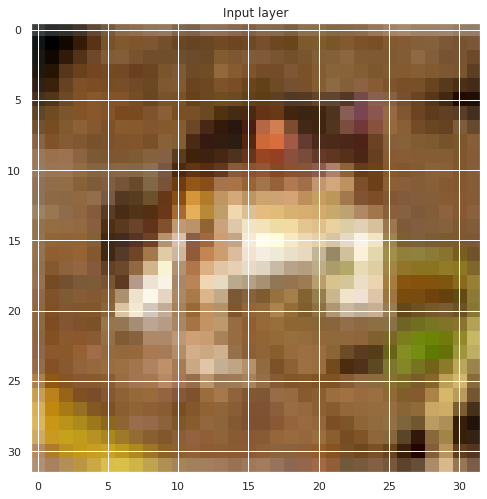

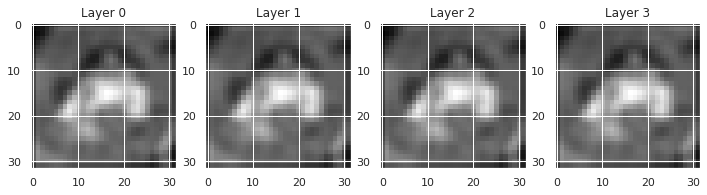

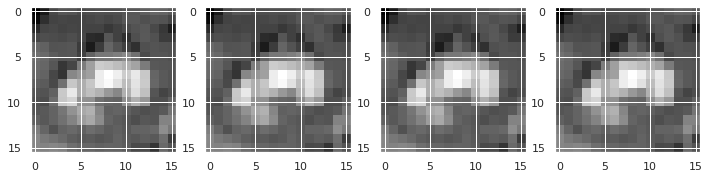

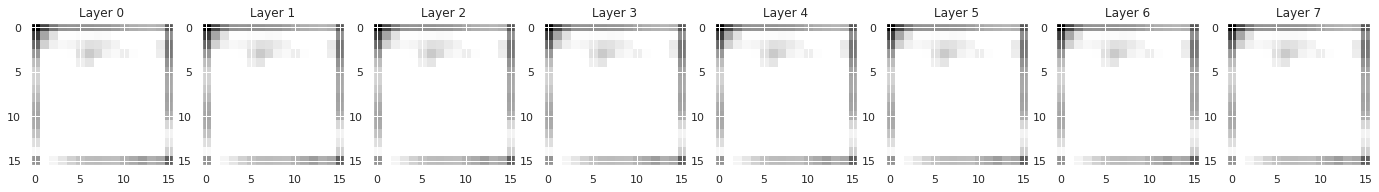

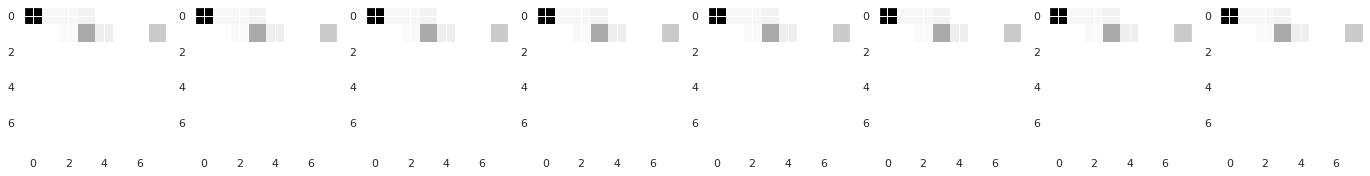

In [476]:
y_1, fl = feed_forward(data['X'][0,:], print_dim=True, show_plot=True)

In [408]:
from sklearn.manifold import TSNE
import seaborn as sns

In [409]:
def t_SNE_plots(X, y):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    palette = sns.color_palette("bright", 10)

    tsne = TSNE()
    embeddings = tsne.fit_transform(X)
    sns.scatterplot(embeddings[:,0], embeddings[:,1], hue=y, legend='full', palette=palette)

In [477]:
X = np.zeros((10, 32, 32, 3, 5), dtype=int)

classes = np.arange(10)
counter = np.zeros(10, dtype=int)
for i in range(len(data['Y'])):
    for j in range(10):
        if data['Y'][i] == classes[j]:
            if counter[j] < 5:
                X[classes[j], :, :, :, counter[j]] = data['X'][i, :, :, :]
            counter[j] += 1

In [479]:
X_fl_bp = np.zeros((512, 50))
X_fl_ran = np.zeros((512, 50))

Y = np.zeros(50)
for i in range(50):
    print("Idx {}".format(i))
    X_fl_bp[:, i] = feed_forward(X[i%10, :, :, :, i//10], show_plot=False)[1][0]
    X_fl_ran[:, i] = feed_forward(X[i%10, :, :, :, i//10], init_type='random', show_plot=False)[1][0]
    Y[i] = classes[i%10]

Idx 0
Idx 1
Idx 2
Idx 3
Idx 4
Idx 5
Idx 6
Idx 7
Idx 8
Idx 9
Idx 10
Idx 11
Idx 12
Idx 13
Idx 14
Idx 15
Idx 16
Idx 17
Idx 18
Idx 19
Idx 20
Idx 21
Idx 22
Idx 23
Idx 24
Idx 25
Idx 26
Idx 27
Idx 28
Idx 29
Idx 30
Idx 31
Idx 32
Idx 33
Idx 34
Idx 35
Idx 36
Idx 37
Idx 38
Idx 39
Idx 40
Idx 41
Idx 42
Idx 43
Idx 44
Idx 45
Idx 46
Idx 47
Idx 48
Idx 49


In [480]:
X_fl.shape

(512, 50)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


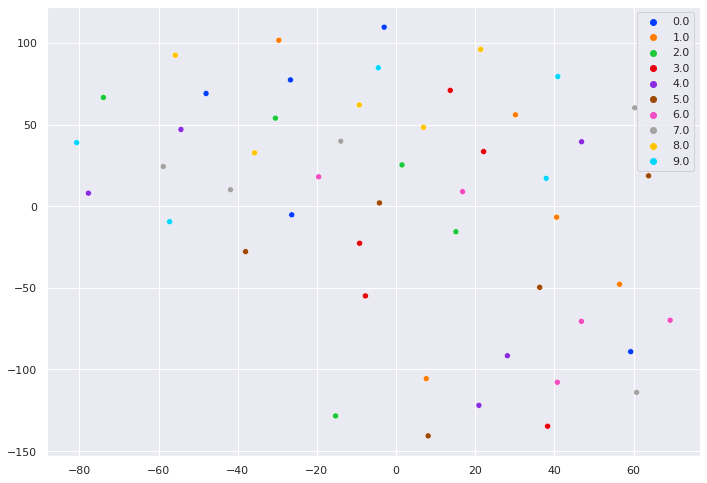

In [483]:
t_SNE_plots(X_fl_bp.T, Y)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


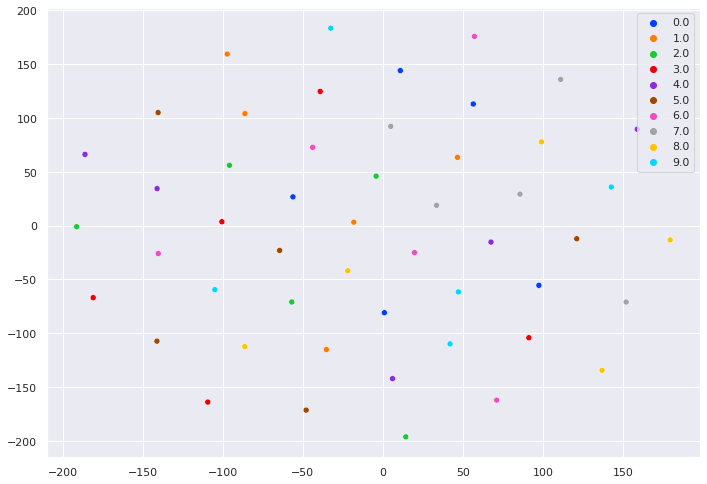

In [484]:
t_SNE_plots(X_fl_ran.T, Y)

In [434]:
from sklearn.datasets import load_digits

In [435]:
X, y = load_digits(return_X_y=True)


In [436]:
X.shape

(1797, 64)

In [441]:
np.unique(Y)

array([0., 1., 2., 3., 4.])

3


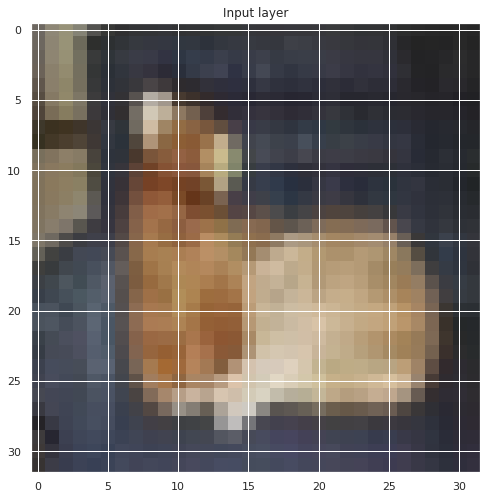

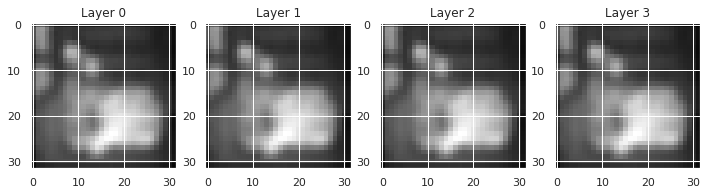

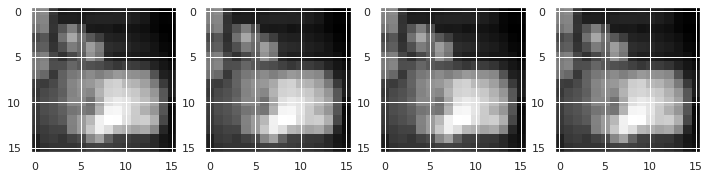

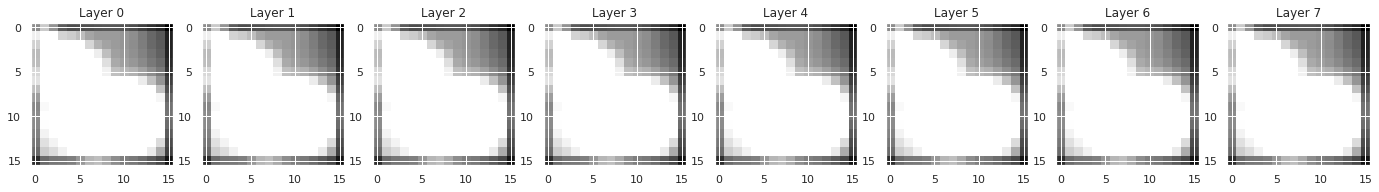

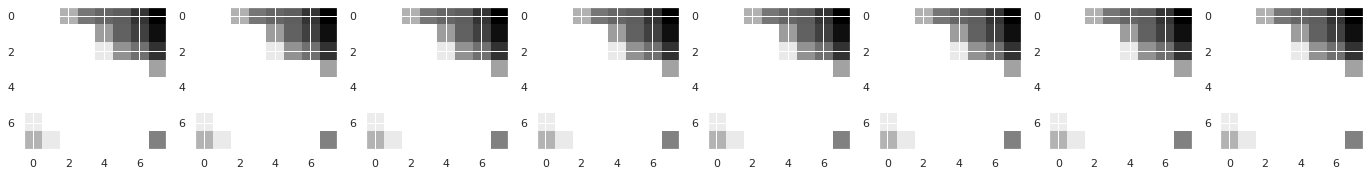

In [465]:
i=13
print(classes[i%10])
a,b = feed_forward(X[i%10, :, :, :, i//10], show_plot=True)